In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras import regularizers

In [ ]:
image_size = (224, 224)
batch_size = 16

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size[0], image_size[1], 3),
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Preprocess the input images and apply augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # fill_mode='nearest'
)

In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dwipurwanto","key":"d0f921ab48b2abde45af149d189ce50e"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d dwipurwanto/plant1 -p "/tmp/plantdataset.zip"

 99% 471M/476M [00:05<00:00, 111MB/s] 
100% 476M/476M [00:06<00:00, 83.1MB/s]


In [ ]:
#unzip
local_zip = '/tmp/plantdataset.zip/plant1.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
#lalu tentukan train dan valid

In [ ]:
base_path = "/tmp/Plant Dataset"
source_path = os.path.join(base_path)
train_path = os.path.join(source_path, "Train")
valid_path = os.path.join(source_path, "Valid")

In [ ]:
# Create train and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)

Found 9300 images belonging to 31 classes.
Found 1550 images belonging to 31 classes.


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

with tf.device("GPU"):
    model = Sequential()
    model.add(base_model)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(31, activation='softmax'))

# Compile the model
# learning_rate = 0.001
optimizer = Adam(learning_rate=0.001, amsgrad=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
# model.summary()

In [ ]:
checkpoint_callback = ModelCheckpoint('chili_model_weights.h5', save_best_only=True, save_weights_only=True)
early_stopping_callback = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_loss')

In [ ]:
epoch = 50
with tf.device('GPU'):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epoch,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]
    )

Epoch 1/50
582/582 [==============================] - 168s 267ms/step - loss: 3.1125 - accuracy: 0.5910 - val_loss: 1.6868 - val_accuracy: 0.6645 - lr: 0.0010
Epoch 2/50
582/582 [==============================] - 150s 257ms/step - loss: 1.6683 - accuracy: 0.6628 - val_loss: 1.7683 - val_accuracy: 0.6303 - lr: 0.0010
Epoch 3/50
582/582 [==============================] - 152s 261ms/step - loss: 1.5884 - accuracy: 0.6771 - val_loss: 1.6074 - val_accuracy: 0.6568 - lr: 0.0010
Epoch 4/50
582/582 [==============================] - 149s 257ms/step - loss: 1.5274 - accuracy: 0.6880 - val_loss: 1.5187 - val_accuracy: 0.6897 - lr: 0.0010
Epoch 5/50
582/582 [==============================] - 149s 255ms/step - loss: 1.4874 - accuracy: 0.6835 - val_loss: 1.5661 - val_accuracy: 0.6652 - lr: 0.0010
Epoch 6/50
582/582 [==============================] - 149s 256ms/step - loss: 1.4429 - accuracy: 0.6996 - val_loss: 1.5693 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 7/50
582/582 [==========================

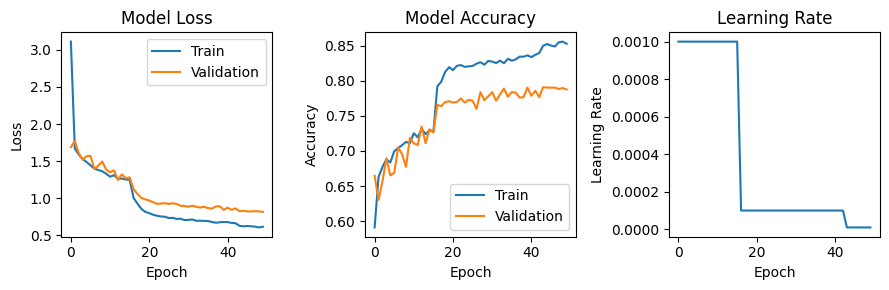

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(['Train', 'Validation'], loc='upper right')

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['Train', 'Validation'], loc='lower right')

axes[2].plot(history.history['lr'])
axes[2].set_title('Learning Rate')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')

plt.tight_layout()
plt.show()

In [ ]:
export_dir = 'saved_model/plant/3'
tf.saved_model.save(model, export_dir)

In [ ]:
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

# New Section

In [ ]:
import pathlib
tflite_model_file = pathlib.Path('/tmp/plant.tflite')
tflite_model_file.write_bytes(tflite_model)

2944736